In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend_laplace import PDESolverLaplace
from PDE_solver_backend_laplace import AggregateLaplace

In [3]:
def make_points_inside(Nd):
    return 2*np.random.rand(Nd,2)-1

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

In [33]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)
f_symbolic

65*pi**2*cos(4*pi*x)*cos(pi*y/2)/4

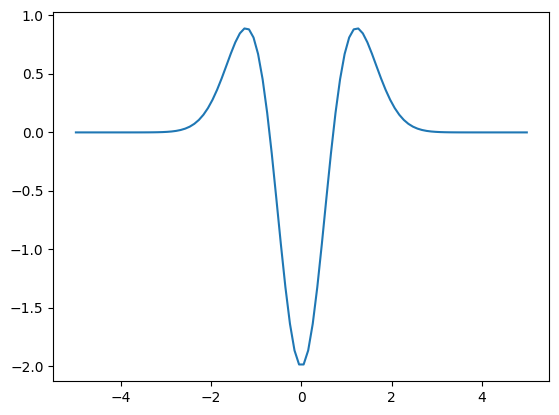

In [37]:
gaussian=exp(-(x)**2)

gaussian_der=lambdify(x,diff(gaussian,x,x))
plt.plot(np.linspace(-5,5,100),[gaussian_der(x) for x in np.linspace(-5,5,100)])

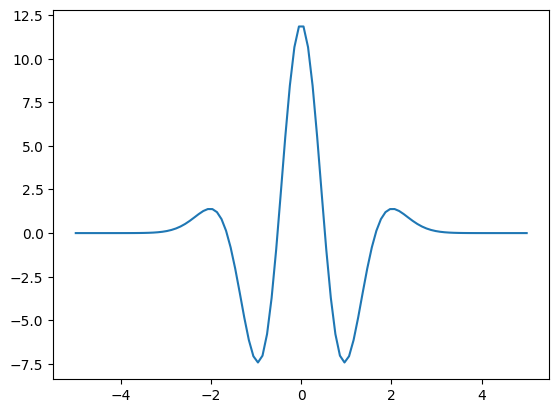

In [38]:

gaussian_der_der=lambdify(x,diff(diff(gaussian,x,x),x,x))
plt.plot(np.linspace(-5,5,100),[gaussian_der_der(x) for x in np.linspace(-5,5,100)])

In [5]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.zeros_like(x)#np.power(x,3)
dtau=lambda x:np.zeros_like(x)

In [6]:
int_point_number=3000
ext_point_number=100
X_int=make_points_inside(int_point_number)
X_boundary=make_points_boundary(ext_point_number)
X_all=np.concatenate([X_int,X_boundary])

u=PDESolverLaplace(X_int=X_int,X_boundary=X_boundary,sigma=0.1)
u.fit(f,real_u,nugget=1e-5)

In [7]:
def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

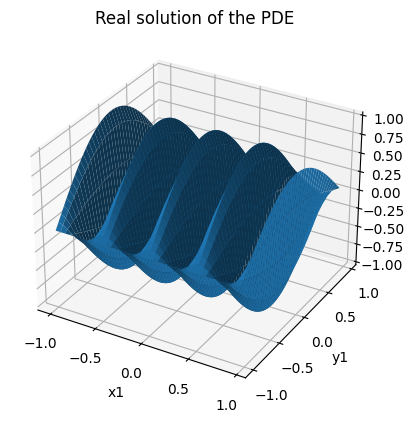

In [8]:
fig=plot_function(real_u)
plt.title('Real solution of the PDE')
plt.show()

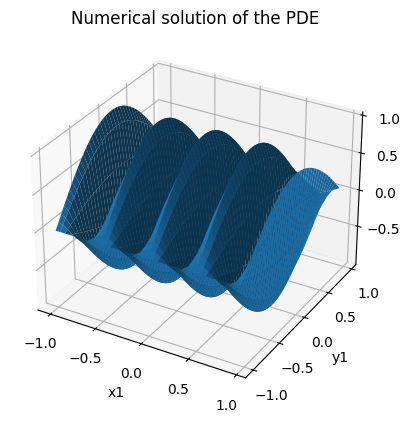

In [9]:
fig=plot_vectorized_function(u)
plt.title('Numerical solution of the PDE')
plt.show()

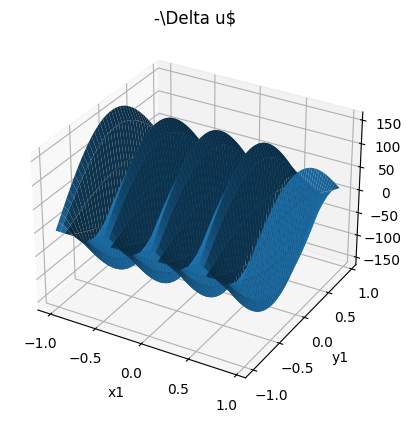

In [10]:
fig=plot_vectorized_function(lambda x:-u.laplacian(x))
#fig=plot_vectorized_function(lambda x:u.laplacian(x))
plt.title('-\Delta u$')
plt.show()

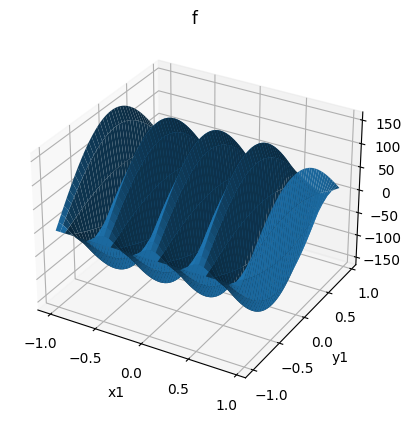

In [11]:
fig=plot_function(f)
plt.title('f')
plt.show()

In [12]:
X_int_left=make_points_inside(int_point_number)
X_int_right=make_points_inside(int_point_number)
X_boundary_left=make_points_boundary(ext_point_number)
X_boundary_right=make_points_boundary(ext_point_number)

In [13]:

print((pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean())
sigma=0.1

0.018195981925852665


In [14]:
#u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<0],X_boundary=X_boundary_left[X_boundary_left[:,0]<0],sigma=sigma,name='left')
u_left=PDESolverLaplace(X_int=X_int_left[X_int_left[:,0]<0],X_boundary=X_boundary_left,sigma=sigma,name='left')
u_left.fit(f,real_u,nugget=1e-5)
#u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right[X_boundary_right[:,0]>-0.2],sigma=sigma,name='right')
u_right=PDESolverLaplace(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right,sigma=sigma,name='right')
u_right.fit(f,real_u,nugget=1e-5)

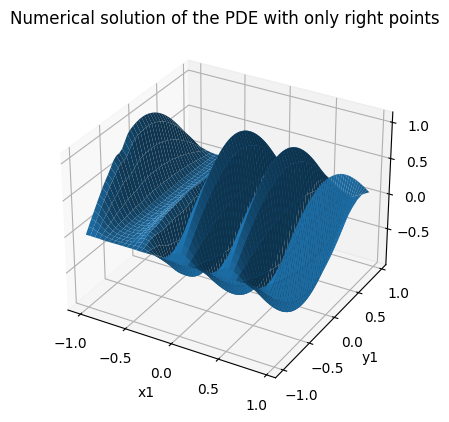

In [15]:
fig=plot_vectorized_function(u_right)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

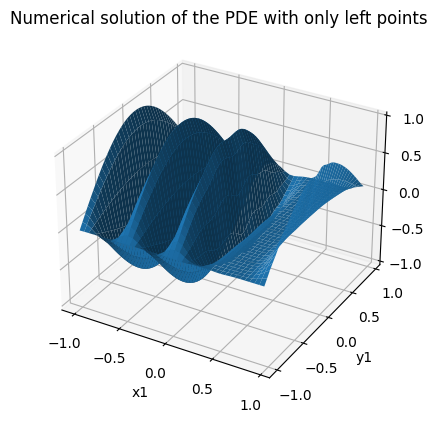

In [16]:
fig=plot_vectorized_function(u_left)
plt.title('Numerical solution of the PDE with only left points')
plt.show()

In [17]:
aggregate=AggregateLaplace([u_left,u_right],nugget=1e-5)

M [[-0.00237493  0.00130319]
 [-0.00043647  0.00163976]
 [ 0.00016913  0.00136737]
 ...
 [ 0.03142781 -0.0236294 ]
 [ 0.05787313  0.0245626 ]
 [ 0.08360144  0.06307218]]
COV mat [[[0.99782333 0.99733211]
  [0.99733211 0.99956422]]

 [[0.99990754 0.899724  ]
  [0.899724   0.90002261]]

 [[0.99997292 0.90855846]
  [0.90855846 0.90856088]]

 ...

 [[0.37970971 0.37970276]
  [0.37970276 0.99999421]]

 [[0.38292968 0.38289828]
  [0.38289828 1.00000167]]

 [[0.65946472 0.65915991]
  [0.65915991 0.99990747]]]
COV Y [[0.99781316 0.99955422]
 [0.99989687 0.90001261]
 [0.99996212 0.90855088]
 ...
 [0.37969971 0.99997961]
 [0.38291968 0.99998707]
 [0.65945472 0.99989533]]
alpha [[1.80634626e-01 8.19758741e-01]
 [9.97022537e-01 3.29713892e-03]
 [9.99964651e-01 2.70129484e-05]
 ...
 [1.05869389e-05 9.99981376e-01]
 [1.14224784e-04 9.99941663e-01]
 [1.34625987e-03 9.99100376e-01]]


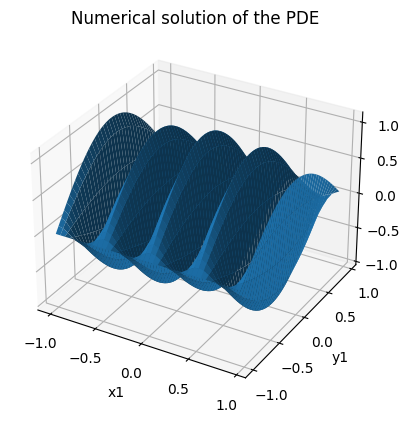

In [18]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [19]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U = u(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))


M [[-0.00237493  0.00130319]
 [-0.00188063  0.00139143]
 [-0.00143879  0.00147301]
 ...
 [ 0.05366567  0.01399228]
 [ 0.05497271  0.01409236]
 [ 0.05576202  0.01378783]]
COV mat [[[0.99782333 0.99733211]
  [0.99733211 0.99956422]]

 [[0.99860382 0.99119763]
  [0.99119763 0.99292319]]

 [[0.99915893 0.97401303]
  [0.97401303 0.97527396]]

 ...

 [[0.48949231 0.48925309]
  [0.48925309 0.99994435]]

 [[0.51245897 0.51207786]
  [0.51207786 0.99983485]]

 [[0.52691757 0.52634403]
  [0.52634403 0.99960401]]]
COV Y [[0.99781316 0.99955422]
 [0.99859361 0.99291319]
 [0.99914874 0.97526396]
 ...
 [0.48948231 0.99993367]
 [0.51244897 0.99982434]
 [0.52690757 0.99959367]]
alpha [[1.80634626e-01 8.19758741e-01]
 [8.11278434e-01 1.90121383e-01]
 [9.52300923e-01 4.89200475e-02]
 ...
 [9.37349350e-04 9.99530701e-01]
 [1.50482295e-03 9.99218770e-01]
 [2.27800439e-03 9.98790165e-01]]


In [20]:
U_real_left=U_real.reshape(X.shape)[X<0]
U_real_right=U_real.reshape(X.shape)[X>-0.2]
U_left_left=U_left.reshape(X.shape)[X<0]
U_right_right=U_right.reshape(X.shape)[X>-0.2]

In [21]:
print(np.linalg.norm(U-U_real,ord=np.inf))
np.linalg.norm(U_agg-U_real,ord=np.inf)

0.012331388892283746


0.11747488855555266

In [22]:
x_sample=np.array([[-0.7,-0.6]])
print(real_u(x_sample[0]))
aggregate(x_sample)

-0.47552825814757677
M [[-0.4764593  0.0067505]]
COV mat [[[9.97785458e-01 1.29186505e-04]
  [1.29186505e-04 1.33296669e-04]]]
COV Y [[9.97776379e-01 1.23296668e-04]]
alpha [[ 0.99999662 -0.04418265]]


array([-0.47675595])

In [25]:
u_left.covariate_with_sol(x_sample)

array([0.99777638])

In [26]:
u_left.sigma

0.1

In [27]:
u_left.covariate_with_sol(x_sample)

array([0.99777638])

In [ ]:
aggregate.alpha(x_sample)

COV mat [[[9.97830109e-01 1.31537661e-04]
  [1.31537661e-04 1.34675988e-04]]]
COV Y [[9.97820109e-01 1.24675988e-04]]


array([[ 0.99999669, -0.05094626]])

In [ ]:
u_left.covariate_with_other(u_left,x_sample,1e-6)

array([2.27268901e+25])

In [28]:
cov_left=u_left.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_right=u_right.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_inter=u_right.covariate_with_other(u_left,np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))

COV mat [[[0.99782333 0.99733211]
  [0.99733211 0.99956422]]

 [[0.99860382 0.99119763]
  [0.99119763 0.99292319]]

 [[0.99915893 0.97401303]
  [0.97401303 0.97527396]]

 ...

 [[0.48949231 0.48925309]
  [0.48925309 0.99994435]]

 [[0.51245897 0.51207786]
  [0.51207786 0.99983485]]

 [[0.52691757 0.52634403]
  [0.52634403 0.99960401]]]
COV Y [[0.99781316 0.99955422]
 [0.99859361 0.99291319]
 [0.99914874 0.97526396]
 ...
 [0.48948231 0.99993367]
 [0.51244897 0.99982434]
 [0.52690757 0.99959367]]


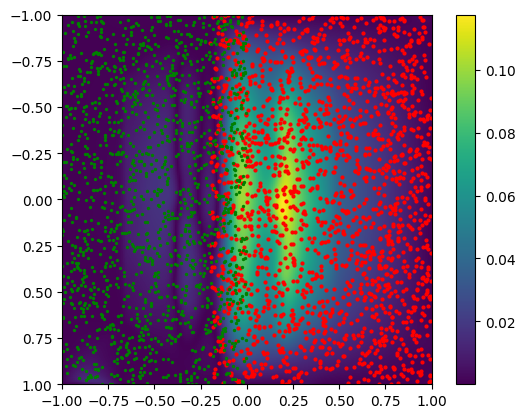

In [30]:
ax=plt.subplot()
clip_error=np.linalg.norm(U_agg-U_real,ord=np.inf)
im = ax.imshow(np.clip(np.abs(U_agg-U_real),0,clip_error).reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
ax.scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
plt.colorbar(im)

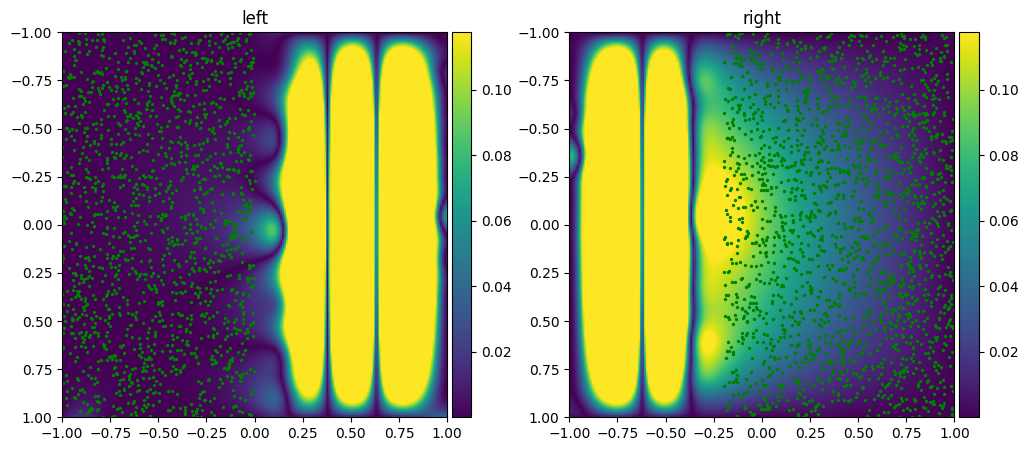

In [40]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
clip_error=np.linalg.norm(U_agg-U_real,ord=np.inf)
np.clip(np.abs(U_left-U_real),0,clip_error)
im = axes[0].imshow(np.clip(np.abs(U_left-U_real),0,clip_error).reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.clip(np.abs(U_right-U_real),0,clip_error).reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

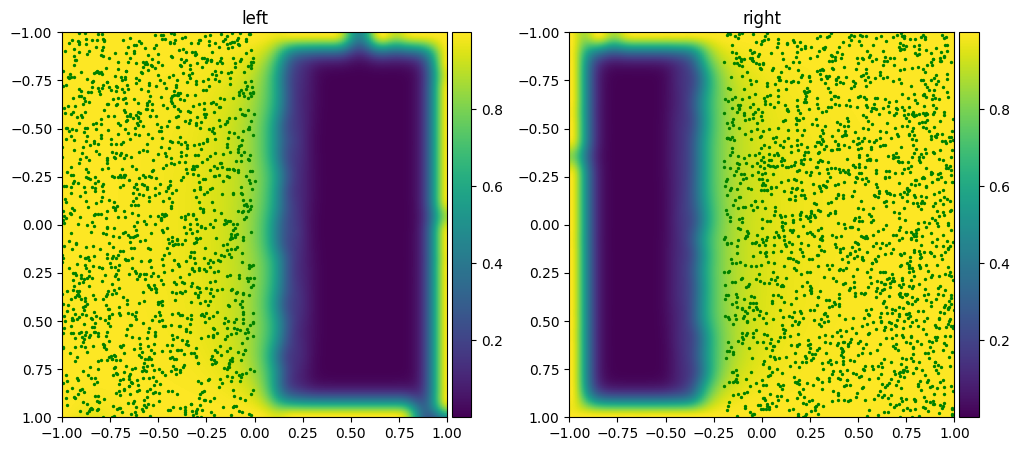

In [32]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(cov_left.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(cov_right.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

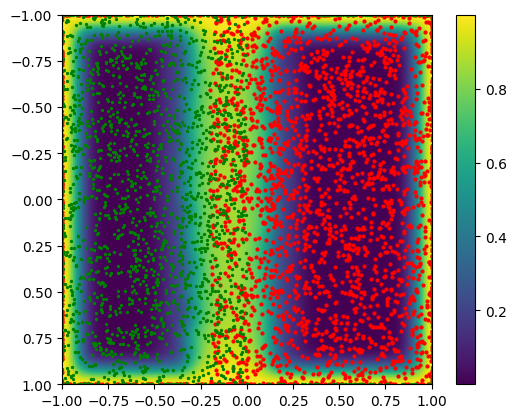

In [ ]:
ax=plt.subplot()
im = ax.imshow(cov_inter.reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
ax.scatter(u_right.X_boundary[:,0],u_right.X_boundary[:,1],c='r',s=4)
ax.scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
ax.scatter(u_left.X_boundary[:,0],u_left.X_boundary[:,1],c='g',s=2)
plt.colorbar(im)

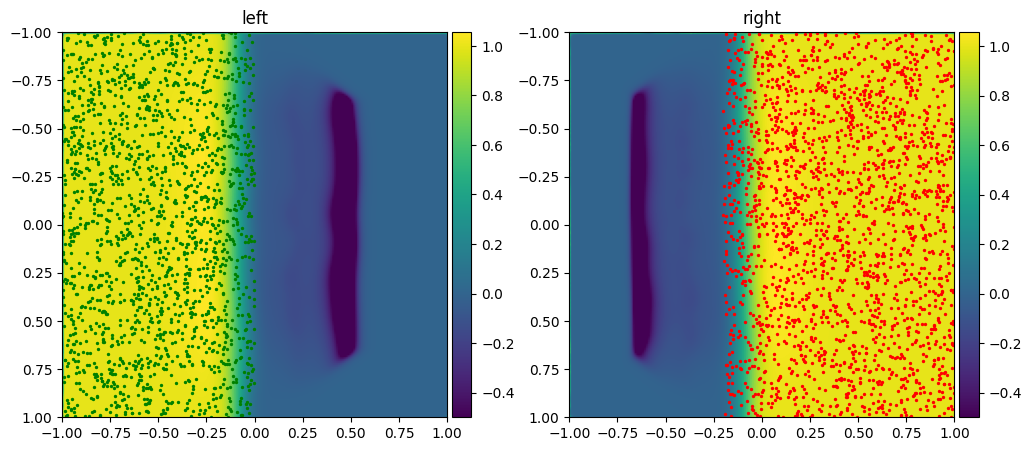

In [ ]:
clipped=np.clip(alpha,-0.5,1.5)

fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(clipped[:,0].reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(clipped[:,1].reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=2)
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [ ]:
print(1/0)

In [ ]:
def make_an_aggregate(N_int,N_boundary,nugget=1e-4,sigma=None):
    X_int_left=make_points_inside(N_int)
    X_int_right=make_points_inside(N_int)
    X_boundary_left=make_points_boundary(N_boundary)
    X_boundary_right=make_points_boundary(N_boundary)
    if sigma is None:
        print(3/0)
        sigma=3*(pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean()
    u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<0.2],X_boundary=X_boundary_left,sigma=sigma,name='left')
    u_left.fit(f,real_u,tau,dtau,nugget=1e-5)
    u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right,sigma=sigma,name='right')
    u_right.fit(f,real_u,tau,dtau,nugget=1e-5)

    aggregate=Aggregate([u_left,u_right],sigma=sigma,nugget=nugget)
    return u_left,u_right,aggregate

def get_error(aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    return np.linalg.norm(U_real-U_agg),np.linalg.norm(U_real-U_agg,ord=np.inf)

def make_plot(u_left,u_right,aggregate,clip=(-0.5,1.5)):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))
    alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))
    clipped=np.clip(alpha,clip[0],clip[1])


    fig,axes=plt.subplots(3,2,figsize=(30,30))
    im = axes[0,0].imshow(np.abs(U_left-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[0,0].title.set_text('error of left model')

    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im2 = axes[0,1].imshow(np.abs(U_right-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=4)
    axes[0,1].title.set_text('error of right model')

    divider = make_axes_locatable(axes[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')


    im3 = axes[1,0].imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,0].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[1,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=6)
    axes[1,0].title.set_text('error of aggregate')
    divider = make_axes_locatable(axes[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    im4 = axes[1,1].imshow(np.abs(U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,1].title.set_text('absolute value of solution')
    divider = make_axes_locatable(axes[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical')

    im5 = axes[2,0].imshow(clipped[:,0].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[2,0].title.set_text('alpha left')

    divider = make_axes_locatable(axes[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical')

    im6 = axes[2,1].imshow(clipped[:,1].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[2,1].title.set_text('alpha right')

    divider = make_axes_locatable(axes[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical')

    plt.show()

    


In [ ]:
u_left,u_right,aggregate=make_an_aggregate(N_int=2000,N_boundary=500,nugget=0,sigma=0.1)

Current residual 5.030e-13: : 2it [00:00,  2.37it/s]
Current residual 2.788e-13: : 2it [00:00,  2.07it/s]


M [[-5.82067701e-05  3.88845405e-14]
 [-4.05363697e-05  8.54828587e-14]
 [-1.71434296e-05  1.85854389e-13]
 ...
 [ 1.10178089e-13  1.46243880e-02]
 [ 5.17254857e-14  1.51888879e-02]
 [ 2.40305642e-14  1.55483006e-02]]
COV mat [[[ 9.99984520e-01  4.74458825e-18]
  [ 4.74458825e-18  7.71241439e-24]]

 [[ 9.99993843e-01  6.65708916e-18]
  [ 6.65708916e-18  3.55813269e-23]]

 [[ 9.99997205e-01  6.98810231e-18]
  [ 6.98810231e-18  1.60723210e-22]]

 ...

 [[ 6.56719979e-23 -2.76135026e-17]
  [-2.76135026e-17  9.99991565e-01]]

 [[ 1.45730175e-23 -1.10005481e-17]
  [-1.10005481e-17  9.99992741e-01]]

 [[ 3.16719355e-24 -3.03361081e-18]
  [-3.03361081e-18  9.99996233e-01]]]
COV Y [[9.99984520e-01 7.71241439e-24]
 [9.99993843e-01 3.55813269e-23]
 [9.99997205e-01 1.60723210e-22]
 ...
 [6.56719979e-23 9.99991565e-01]
 [1.45730175e-23 9.99992741e-01]
 [3.16719355e-24 9.99996233e-01]]
alpha [[ 1.00000000e+00  4.74466169e-18]
 [ 1.00000000e+00  6.65713015e-18]
 [ 1.00000000e+00  6.98812184e-18]
 ..

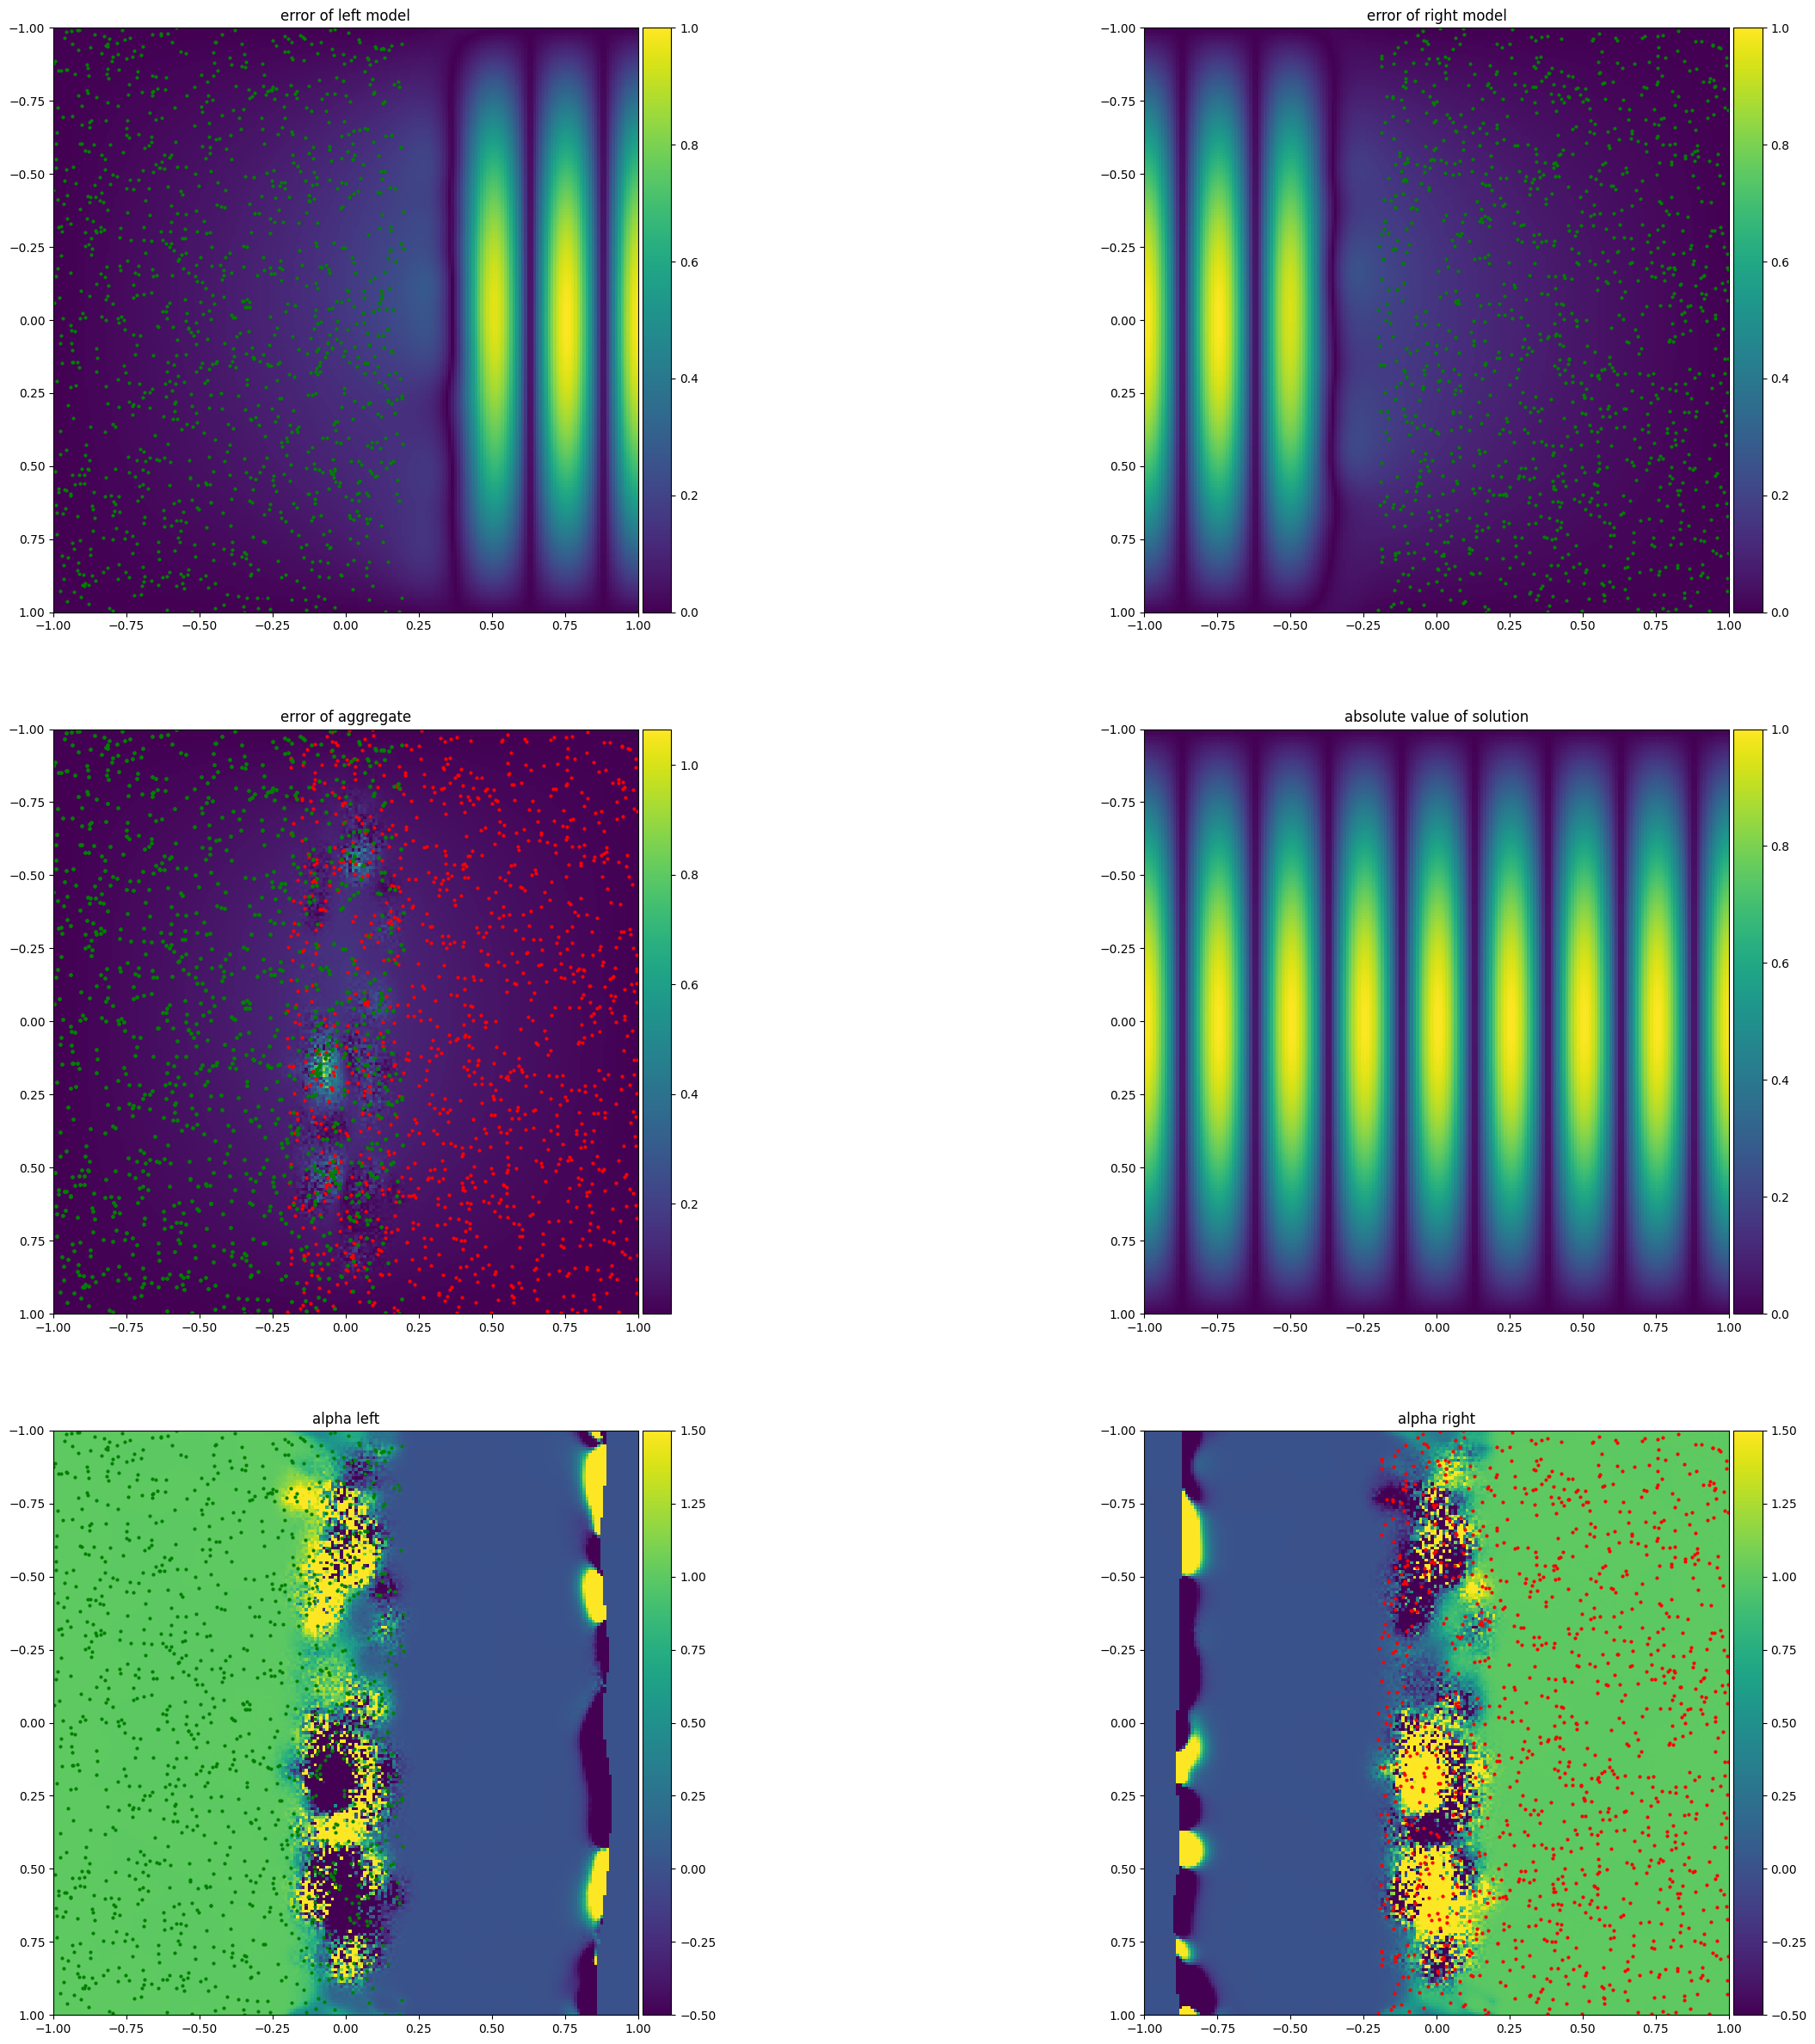

In [ ]:
make_plot(u_left,u_right,aggregate)

In [ ]:
import sys, os

# Disable
#def blockPrint():
#    sys.stdout = open(os.devnull, 'w')

# Restore
#def enablePrint():
#    sys.stdout = sys.__stdout__

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
X_left=X[X<0]
Y_left=Y[X<0]
X_right=X[X>-0.2]
Y_right=Y[X>-0.2]
U_real_left=np.array([real_u([x,y]) for x,y in zip(np.ravel(X_left), np.ravel(Y_left))])
U_real_right=np.array([real_u([x,y]) for x,y in zip(np.ravel(X_right), np.ravel(Y_right))])
Ns=np.linspace(100,10000,10,dtype=np.int32)
errors=[]
for n in Ns:
    print(n)
    with HiddenPrints():
        u_left,u_right,aggregate=make_an_aggregate(N_int=n,N_boundary=n//10,nugget=0,sigma=0.1)
        U_left_left=u_left(np.stack([X_left.flatten(),Y_left.flatten()],axis=-1))
        U_right_right=u_right(np.stack([X_right.flatten(),Y_right.flatten()],axis=-1))
        errors.append([np.linalg.norm(U_left_left-U_real_left,ord=np.inf),np.linalg.norm(U_right_right-U_real_right,ord=np.inf)])
        
errors=np.array(errors)


Current residual 2.001e-15: : 2it [00:00, 441.02it/s]
Current residual 4.474e-15: : 2it [00:00, 354.74it/s]

100
1200



Current residual 1.169e-13: : 2it [00:00,  8.99it/s]
Current residual 1.398e-13: : 2it [00:00,  9.61it/s]


2300


Current residual 4.358e-13: : 2it [00:01,  1.37it/s]
Current residual 4.757e-13: : 2it [00:01,  1.39it/s]


3400


Current residual 4.503e-13: : 2it [00:06,  3.17s/it]
Current residual 5.473e-13: : 2it [00:06,  3.04s/it]


4500


Current residual 6.643e-13: : 2it [00:16,  8.44s/it]
Current residual 1.183e-12: : 2it [00:18,  9.04s/it]


5600


Current residual 4.066e-13: : 2it [00:36, 18.08s/it]
Current residual 2.593e-13: : 2it [00:37, 18.85s/it]


6700


Current residual 1.460e-13: : 2it [01:02, 31.37s/it]
Current residual 3.499e-13: : 2it [01:04, 32.25s/it]


7800


Current residual 3.860e-13: : 2it [01:54, 57.01s/it]
Current residual 5.642e-13: : 2it [01:52, 56.47s/it]


8900


Current residual 6.024e-13: : 2it [02:57, 88.76s/it]
Current residual 1.820e-13: : 2it [02:58, 89.39s/it]


10000


Current residual 8.287e-13: : 2it [04:25, 132.51s/it]
Current residual 3.343e-13: : 2it [03:42, 111.14s/it]


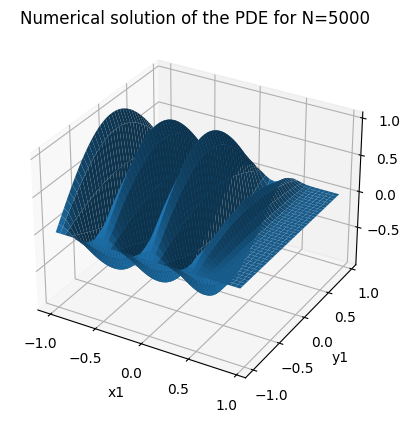

In [ ]:
fig=plot_vectorized_function(u_left,0.05)
plt.title('Numerical solution of the PDE for N=5000')
plt.show()

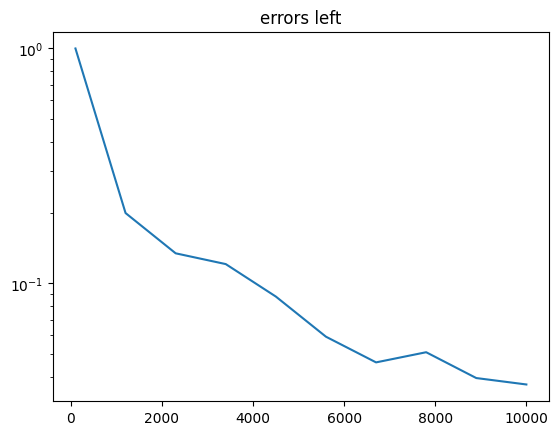

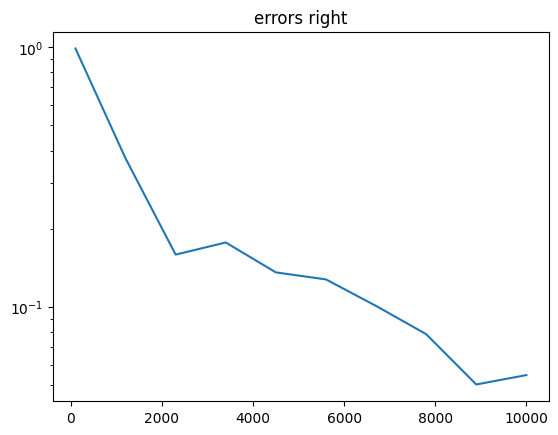

In [ ]:
plt.plot(Ns,errors[:,0])
plt.yscale('log')
plt.title('errors left')
plt.figure()
plt.plot(Ns,errors[:,1])
plt.yscale('log')
plt.title('errors right')
plt.show()

In [ ]:
errors_2=[]
Ns=np.linspace(100,2500,15,dtype=np.int32)
for n in Ns:
    print(n)
    with HiddenPrints():
        u_left,u_right,aggregate=make_an_aggregate(N_int=n,N_boundary=n//10,nugget=0,sigma=0.1)
        L2_error,L_inf_error=get_error(aggregate)
        errors_2.append([L2_error,L_inf_error])

Current residual 2.521e-15: : 2it [00:00, 379.01it/s]
Current residual 1.783e-15: : 2it [00:00, 416.91it/s]

100



Current residual 1.696e-14: : 2it [00:00, 182.46it/s]
Current residual 1.692e-14: : 2it [00:00, 122.84it/s]

271



Current residual 4.413e-14: : 2it [00:00, 75.77it/s]
Current residual 8.014e-14: : 2it [00:00, 70.90it/s]

442



Current residual 1.011e-13: : 2it [00:00, 32.88it/s]
Current residual 1.011e-13: : 2it [00:00, 34.83it/s]

614



Current residual 6.513e-14: : 2it [00:00, 21.18it/s]


785


Current residual 1.046e-13: : 2it [00:00, 19.24it/s]
Current residual 1.191e+00: : 0it [00:00, ?it/s]

957


Current residual 5.353e-14: : 2it [00:00, 13.50it/s]
Current residual 1.028e-13: : 2it [00:00, 13.77it/s]
0it [00:00, ?it/s]

1128


Current residual 1.338e-13: : 2it [00:00,  9.19it/s]
Current residual 1.220e-13: : 2it [00:00, 12.18it/s]
0it [00:00, ?it/s]

1300


Current residual 1.035e-13: : 2it [00:00,  7.23it/s]
Current residual 7.665e-14: : 2it [00:00,  7.76it/s]


1471


Current residual 2.907e-13: : 2it [00:00,  4.93it/s]
Current residual 1.268e-13: : 2it [00:00,  5.00it/s]


1642


Current residual 1.704e-13: : 2it [00:00,  3.46it/s]
Current residual 3.353e-13: : 2it [00:00,  3.42it/s]


1814


Current residual 2.192e-13: : 2it [00:00,  3.98it/s]
Current residual 4.438e-13: : 2it [00:00,  3.90it/s]


1985


Current residual 1.955e-13: : 2it [00:01,  1.75it/s]
Current residual 3.050e-13: : 2it [00:00,  2.02it/s]


2157


Current residual 2.153e-13: : 2it [00:01,  1.20it/s]
Current residual 4.033e-13: : 2it [00:00,  2.09it/s]


2328


Current residual 3.694e-13: : 2it [00:01,  1.53it/s]
Current residual 1.310e-13: : 2it [00:01,  1.57it/s]


2500


Current residual 3.284e-13: : 2it [00:01,  1.12it/s]
Current residual 4.785e-13: : 2it [00:01,  1.24it/s]


In [ ]:
errors_2=np.array(errors_2)

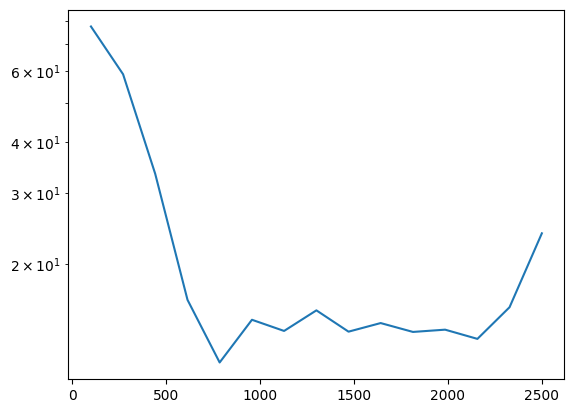

In [ ]:
plt.plot(Ns,errors_2[:,0])
plt.yscale('log')

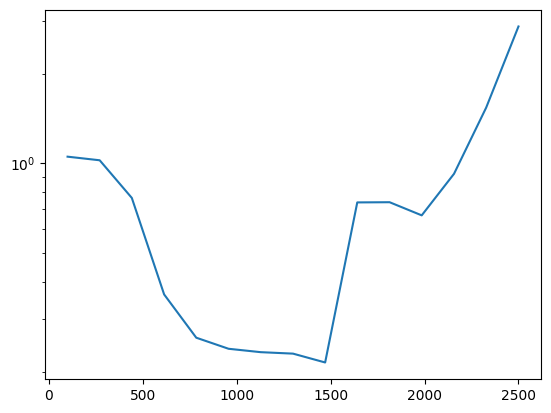

In [ ]:
plt.plot(Ns,errors_2[:,1])
plt.yscale('log')